# Eksplorasi Data Tempat Wisata Indonesia

Notebook ini berisi ekplorasi data tepat-tempat wisata di Indonesia yang telah dikumpulkan melalui scraping.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import joblib
import os
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# konfigurasi tampilan
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
pd.set_option('display.max_column', None)

In [2]:
# download nltk resource
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')


In [3]:
# membaca file csv
df = pd.read_csv('../Scrape_Data/tempat_wisata_indonesia.csv')
print(f"Jumlah data: {len(df)}")
df.head()

Jumlah data: 1169


,id,nama,alamat,rating,jumlah_review,deskripsi,koordinat,url,provinsi,foto,kategori
0,1,Pantai Tebing Lampuuk,"Meunasah Balee, Kec. Lhoknga",4.6,758.0,"Pantai Tebing Lampuuk, yang terletak di Kec. L...","{'latitude': 5.4970038, 'longitude': 95.227854}",https://www.google.com/maps/place/Pantai+Tebin...,Aceh,['https://lh3.googleusercontent.com/gps-cs-s/A...,['pantai']
1,2,Pantai Sawang,"Sawang, Kec. Samudera, Aceh",3.6,31.0,Pantai Sawang atau yang dikenal juga dengan na...,"{'latitude': 5.1545321, 'longitude': 97.2442516}",https://www.google.com/maps/place/Pantai+Sawan...,Aceh,['https://lh3.googleusercontent.com/gps-cs-s/A...,['pantai']
2,3,Nol Kilometer Kota Banda Aceh,"Gampong Pande, Kec. Kuta Raja, Aceh",4.4,661.0,Tugu Nol Kilometer Kota Banda Aceh adalah sebu...,"{'latitude': 5.5826227, 'longitude': 95.3141429}",https://www.google.com/maps/place/Nol+Kilomete...,Aceh,['https://lh3.googleusercontent.com/gps-cs-s/A...,['lainnya']
3,4,Pantai Ulee Lheue,"Ulee Lheue, Kec. Meuraxa, Aceh",4.5,625.0,Pantai Ulee Lheue di Banda Aceh adalah tempat ...,"{'latitude': 5.5643903, 'longitude': 95.2923091}",https://www.google.com/maps/place/Pantai+Ulee+...,Aceh,['https://lh3.googleusercontent.com/gps-cs-s/A...,['pantai']
4,5,Pantai Ujong Kareung,NaN,4.3,654.0,"Pantai Ujong Kareung, yang sering disebut Pant...","{'latitude': 4.124597, 'longitude': 96.1279608}",https://www.google.com/maps/place/Pantai+Ujong...,Aceh,['https://lh3.googleusercontent.com/gps-cs-s/A...,['pantai']


## 1. Ekplorasi Data Awal

In [4]:
# memeriksa informasi dasar tentang dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1169 entries, 0 to 1168
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1169 non-null   int64  
 1   nama           1169 non-null   object 
 2   alamat         1167 non-null   object 
 3   rating         1168 non-null   float64
 4   jumlah_review  1168 non-null   float64
 5   deskripsi      1169 non-null   object 
 6   koordinat      1169 non-null   object 
 7   url            1169 non-null   object 
 8   provinsi       1169 non-null   object 
 9   foto           1169 non-null   object 
 10  kategori       1169 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 100.6+ KB


In [5]:
# memeriksa data yang hilang (missing value)
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})
missing_df.sort_values(by='Missing Values', ascending=False)

,Missing Values,Percentage
alamat,2,0.171086
rating,1,0.085543
jumlah_review,1,0.085543
id,0,0.000000
nama,0,0.000000
deskripsi,0,0.000000
koordinat,0,0.000000
url,0,0.000000
provinsi,0,0.000000
foto,0,0.000000


In [6]:
# Menghapus baris dengan missing values pada kolom 'alamat', 'jumlah_review', dan 'rating'
df = df.dropna(subset=['alamat', 'jumlah_review', 'rating'])

In [7]:
# Memeriksa data yang hilang setelah penghapusan
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})
print("\nData yang hilang setelah penghapusan:")
print(missing_df.sort_values(by='Missing Values', ascending=False))


Data yang hilang setelah penghapusan:
               Missing Values  Percentage
id                          0         0.0
nama                        0         0.0
alamat                      0         0.0
rating                      0         0.0
jumlah_review               0         0.0
deskripsi                   0         0.0
koordinat                   0         0.0
url                         0         0.0
provinsi                    0         0.0
foto                        0         0.0
kategori                    0         0.0


In [8]:
# Memeriksa jumlah baris setelah penghapusan
print(f"\nJumlah baris setelah penghapusan: {len(df)}")


Jumlah baris setelah penghapusan: 1167


In [9]:
# statistik deskriptif untuk kolom numerik
df.describe() 

,id,rating,jumlah_review
count,1167.000000,1167.000000,1167.000000
mean,585.548415,4.425878,184.203093
std,337.462747,0.236684,240.327863
min,1.000000,3.000000,1.000000
25%,293.500000,4.300000,7.994000
50%,586.000000,4.400000,77.000000
75%,877.500000,4.600000,262.000000
max,1169.000000,5.000000,999.000000


## 2. Ekplorasi Rating dan Jumlah Review

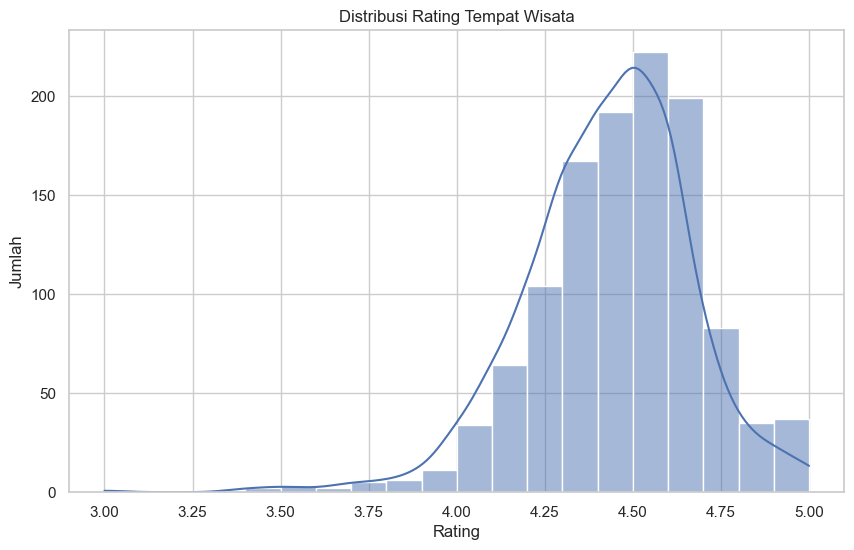

In [10]:
# distribusi rating
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Distribusi Rating Tempat Wisata')
plt.xlabel('Rating') 
plt.ylabel('Jumlah')
plt.show()

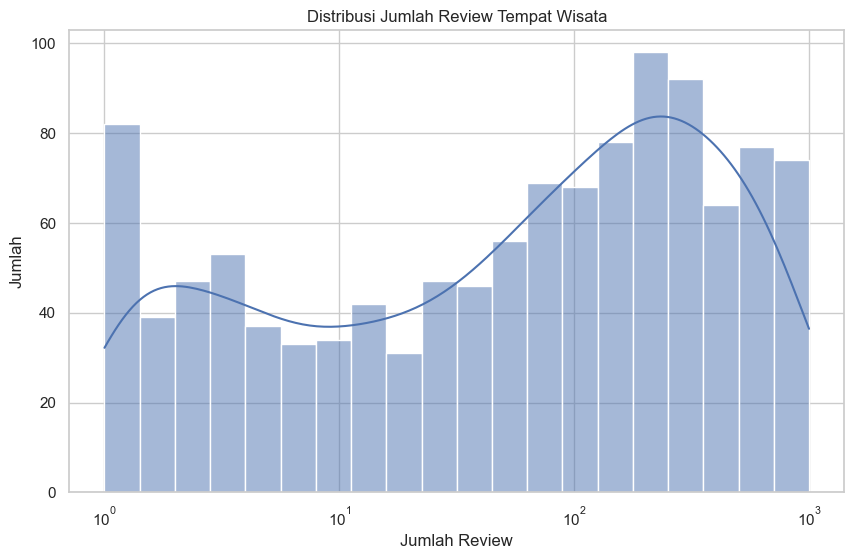

In [11]:
# distribusi jumlah review (dengan skala log)
plt.figure(figsize=(10, 6))
sns.histplot(df['jumlah_review'], bins=20, kde=True, log_scale=True)
plt.title('Distribusi Jumlah Review Tempat Wisata')
plt.xlabel('Jumlah Review')
plt.ylabel('Jumlah')
plt.show() 

## 3. Ekplorasi Kategori Wisata

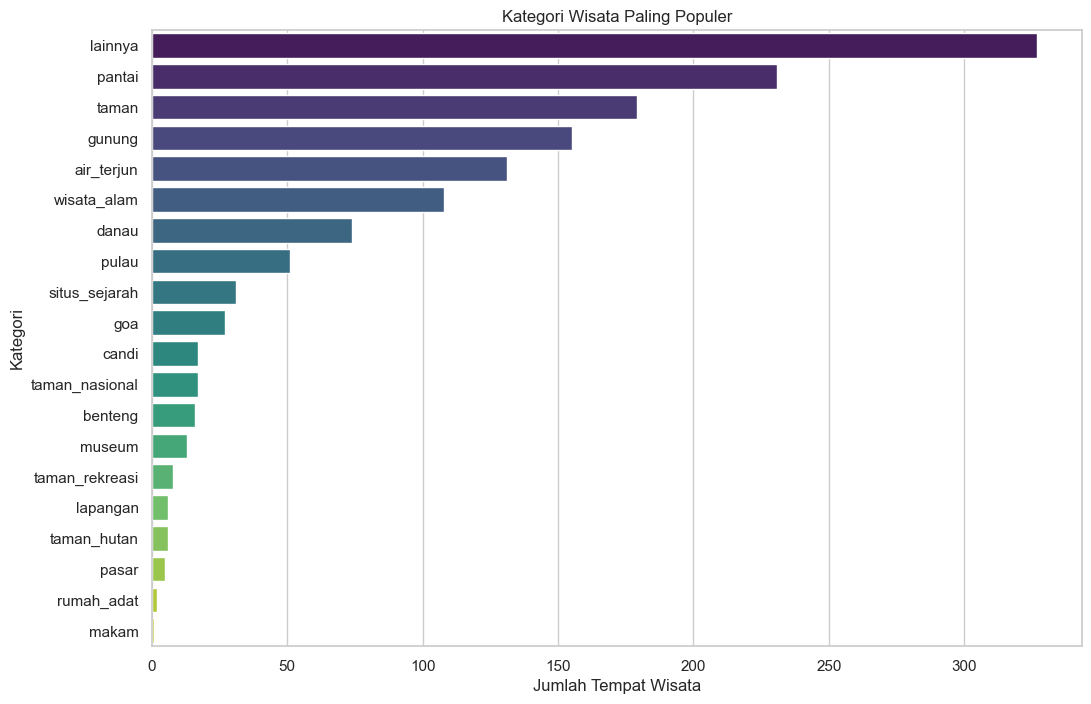

In [12]:
# konversi string kategori menjadi list
df['kategori_list'] = df['kategori'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# hitung frekuensi setiap kategori
all_categories = [category for sublist in df['kategori_list'] for category in sublist]
category_counts = Counter(all_categories)

# buat dataframe untuk visualisasi
category_df = pd.DataFrame({'Category': list(category_counts.keys()), 'Count': list(category_counts.values())})
category_df = category_df.sort_values(by='Count', ascending=False)

# plot bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Category', data=category_df, palette='viridis')
plt.title('Kategori Wisata Paling Populer')
plt.xlabel('Jumlah Tempat Wisata')
plt.ylabel('Kategori')
plt.show()

## 4. Ekplorasi Berdasarakan Provinsi

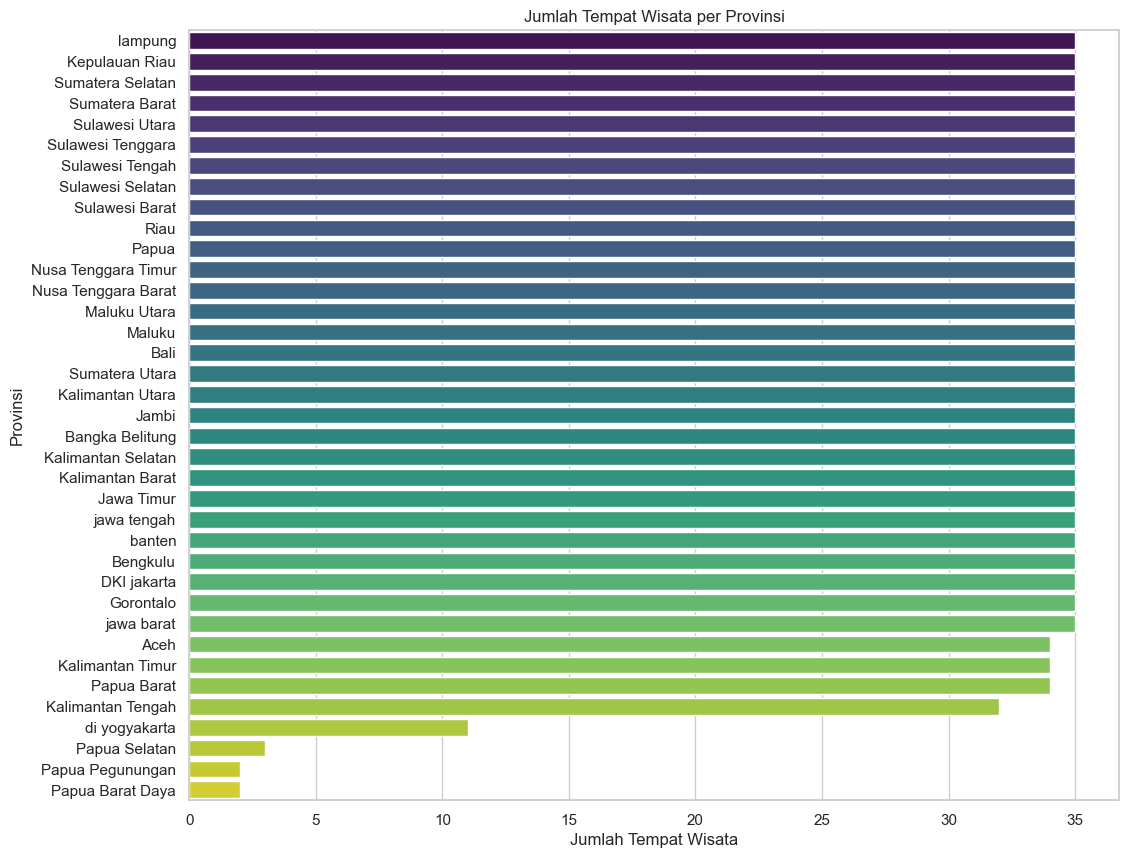

In [13]:
# jumlah tempat wisata per provinsi
provinsi_counts = df['provinsi'].value_counts().reset_index()
provinsi_counts.columns = ['Provinsi', 'Jumlah Tempat Wisata']

# plot bar chart
plt.figure(figsize=(12, 10))
sns.barplot(x='Jumlah Tempat Wisata', y='Provinsi', data=provinsi_counts, palette='viridis')
plt.title('Jumlah Tempat Wisata per Provinsi')
plt.xlabel('Jumlah Tempat Wisata')
plt.ylabel('Provinsi')
plt.show()

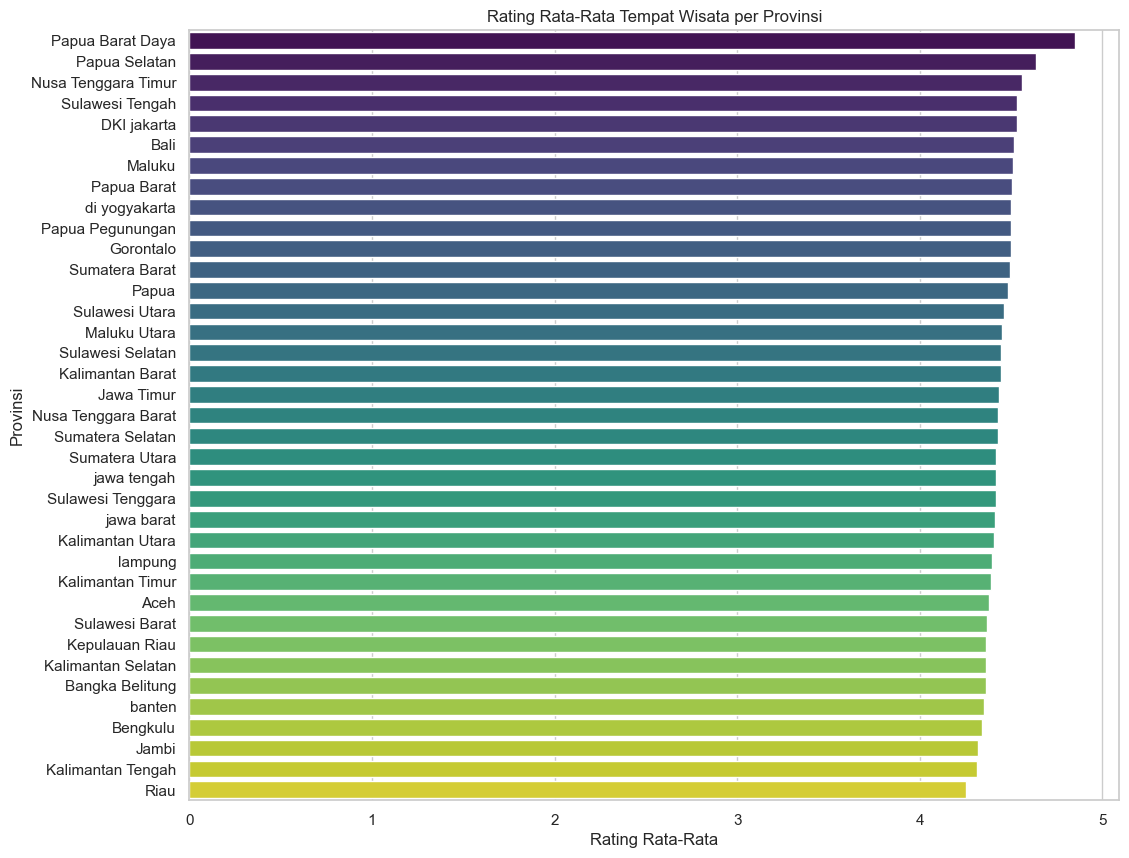

In [14]:
# rating rata-rata per provinsi
rating_provinsi = df.groupby('provinsi')['rating'].mean().reset_index()
rating_provinsi = rating_provinsi.sort_values(by='rating', ascending=False)

# plot bar chart
plt.figure(figsize=(12, 10))
sns.barplot(x='rating', y='provinsi', data=rating_provinsi, palette='viridis')
plt.title('Rating Rata-Rata Tempat Wisata per Provinsi')
plt.xlabel('Rating Rata-Rata')
plt.ylabel('Provinsi')
plt.show()

## 5. Analisis Korelasi

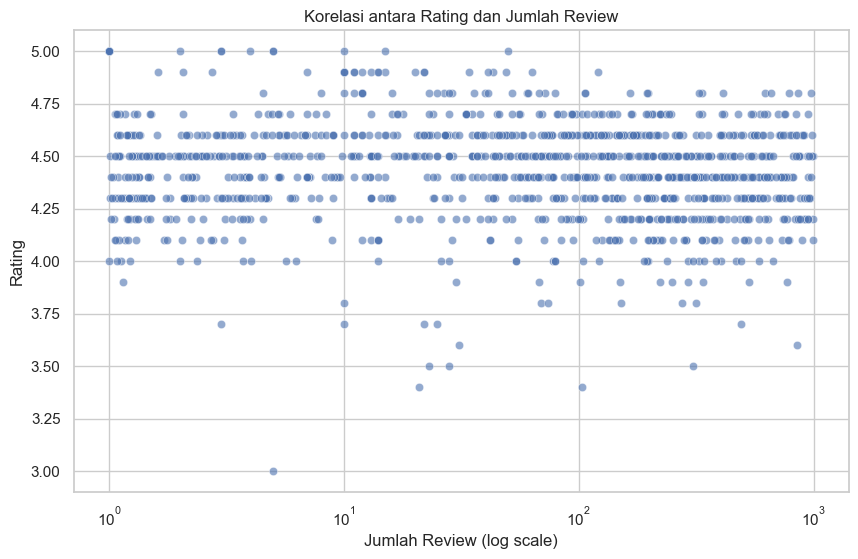

Korelasi antara rating dan jumlah review: -0.11


In [15]:
# korelasi antara rating dan jumlah review
plt.figure(figsize=(10, 6))
sns.scatterplot(x='jumlah_review', y='rating', data=df, alpha=0.6)
plt.title('Korelasi antara Rating dan Jumlah Review')
plt.xlabel('Jumlah Review (log scale)')
plt.ylabel('Rating')
plt.xscale('log')
plt.grid(True)
plt.show()

#hitung korelasi antara rating dan jumlah review
correlation = df['rating'].corr(df['jumlah_review'])
print(f"Korelasi antara rating dan jumlah review: {correlation:.2f}")


## 6. Analisis Teks Deskripsi

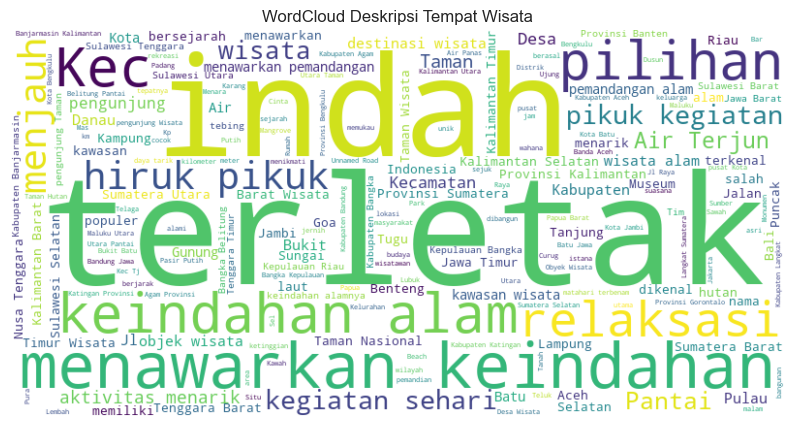

In [16]:
# gabungkan semua deskripsi menjadi satu teks
all_descriptions = ' '.join(df['deskripsi'].dropna().astype(str))

# coba gunakan stopwords indonesia, jika tidak ada gunakan stopwords inggris
try:
    stop_words = set(stopwords.words('indonesian'))
except LookupError:
    stop_words = set(stopwords.words('english'))

# tambahkan stopword kostum
custom_stopwords = ['yang', 'ini', 'dan', 'di', 'dengan', 'untuk', 'dari', 'pada', 'ke', 'adalah']
stop_words.update(custom_stopwords)

# buat wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, max_words=200).generate(all_descriptions)

# tampilkan wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Deskripsi Tempat Wisata')
plt.show()

## 7. Pra-pemrosesan Data untuk Model Rekomendasi 

In [17]:
# fungsi untuk pra-pemrosesan teks
def preprocess_text(text):
    if pd.isna(text):
        return ''
    
    # konversi ke lowercase
    text = text.lower()

    # hapus karakter khusus dan angka
    text = re.sub(r'[^\\w\\s]', ' ', text)
    text = re.sub(r'\\d+', ' ', text)

    # tokenisasi
    tokens = word_tokenize(text)

    # hapus stopwords
    stop_words = set(stopwords.words('indonesian'))     
    tokens = [word for word in tokens if word not in stop_words]

    # stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # gabungkan kembali menjadi satu teks
    return ' '.join(tokens)

In [18]:
# pra-pemrosesan teks pada kolom 'deskripsi'
df['deskripsi_processed'] = df['deskripsi'].apply(preprocess_text)

# konversi kategori dari string ke list
df['kategori_list'] = df['kategori'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# gabungkan kategori menjadi string untuk TF-IDF
df['kategori_string'] = df['kategori_list'].apply(lambda x: ' '.join(x))

# konversi koordinat dari string ke dictionary, lalu ekstrak latitude dan longitude
def extract_coordinates(coord_str):
    if pd.isna(coord_str):
        return np.nan, np.nan
    
    try:
        coord_dict = ast.literal_eval(coord_str) if isinstance(coord_str, str) else coord_str
        return coord_dict.get('latitude', np.nan), coord_dict.get('longitude', np.nan)
    except (ValueError, KeyError):
        return np.nan, np.nan

df['latitude'], df['longitude'] = zip(*df['koordinat'].apply(extract_coordinates))

In [19]:
# cek hasil prepocessing
df[['nama', 'deskripsi', 'deskripsi_processed', 'kategori_list', 'kategori_string', 'latitude', 'longitude']].head()

,nama,deskripsi,deskripsi_processed,kategori_list,kategori_string,latitude,longitude
0,Pantai Tebing Lampuuk,"Pantai Tebing Lampuuk, yang terletak di Kec. L...",s w w s s s s s s,[pantai],pantai,5.497004,95.227854
1,Pantai Sawang,Pantai Sawang atau yang dikenal juga dengan na...,s w s s w s s s,[pantai],pantai,5.154532,97.244252
2,Nol Kilometer Kota Banda Aceh,Tugu Nol Kilometer Kota Banda Aceh adalah sebu...,s w s s w s s,[lainnya],lainnya,5.582623,95.314143
3,Pantai Ulee Lheue,Pantai Ulee Lheue di Banda Aceh adalah tempat ...,w s s w s s,[pantai],pantai,5.564390,95.292309
5,Lapangan Blang Padang,Lapangan Blang Padang adalah sebuah ruang terb...,s s s s w s w s s s w s s s,[lapangan],lapangan,5.549981,95.313674


## 8. Content-Based Filtering

In [20]:
# membuat fitur kombinasi yang terdiri dari deskripsi, kategori, dan nama lokasi
df['fitur_kombinasi'] = df['deskripsi_processed'] + ' ' + df['kategori_string'] + ' ' + df['provinsi'].str.lower()

# Pastikan stop_words adalah list
stop_words = list(stop_words)  # Konversi set ke list

# terapkan TF-IDF pada fitur kombinasi
tfidf = TfidfVectorizer(stop_words=stop_words)
fitur_tfidf = tfidf.fit_transform(df['fitur_kombinasi'])

print(f"Ukuran matriks TF-IDF: {fitur_tfidf.shape}")


Ukuran matriks TF-IDF: (1167, 52)


In [21]:
# hitung cosine similarity
cosine_sim = cosine_similarity(fitur_tfidf, fitur_tfidf)
print(f"Ukuran matriks cosine similarity: {cosine_sim.shape}")

Ukuran matriks cosine similarity: (1167, 1167)


In [22]:
# buat indeks berdasarkan nama tempat wisata
indices = pd.Series(df.index, index=df['nama']).drop_duplicates()

# fungsi untuk rekomendasi berdasarkan content-based
def content_based_recommendations(name, cosine_sim=cosine_sim, df=df, indices=indices, top_n=10):
    # dapatkan indeks tempat wisata dari namanya
    try:
        idx = indices[name]
    except KeyError:
        return "Tempat wisata tidak ditemukan, coba nama lain"
    
    # dapatkan skor kesamaan untuk semua tempat wisata 
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # urutkan tempat wisata berdasarkan skor kesamaan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # dapatkan skor top_n tempat wisata yang paling mirip (kecuali dirinya sendiri)
    sim_scores = sim_scores[1:top_n+1]

    # dapatkan indeks tempat wisata
    attraction_indices = [i[0] for i in sim_scores]

    # kembalikan top_n tempat wisata yang paling mirip
    recommended_place = df.iloc[attraction_indices][['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list']]
    recommended_place['similarity_score'] = [i[1] for i in sim_scores]

    return recommended_place

In [23]:
# contoh rekomendasi content-based
sample_place = df['nama'].iloc[0]
print(f"Rekomendasi untuk: {sample_place} di {df.iloc[0]['provinsi']}")

content_recs = content_based_recommendations(sample_place)
content_recs


Rekomendasi untuk: Pantai Tebing Lampuuk di Aceh


,nama,provinsi,rating,jumlah_review,kategori_list,similarity_score
1,Pantai Sawang,Aceh,3.6,31.000,[pantai],1.000000
3,Pantai Ulee Lheue,Aceh,4.5,625.000,[pantai],1.000000
14,Pantai Paradiso Sabang,Aceh,4.5,421.000,[pantai],1.000000
21,Pantai Ujong Batee,Aceh,4.1,580.000,[pantai],1.000000
23,Pantai Penyu,Aceh,4.3,583.000,[pantai],1.000000
30,Ujoeng Pancu Beach,Aceh,4.5,284.000,[pantai],1.000000
34,Pantai Ulee Lheue,Aceh,4.4,3.743,[pantai],1.000000
2,Nol Kilometer Kota Banda Aceh,Aceh,4.4,661.000,[lainnya],0.864878
11,Anjong Mon Mata Banda Aceh,Aceh,4.4,411.000,[lainnya],0.864878
15,Mon Ceunong,Aceh,4.6,89.000,[lainnya],0.864878


## 9. Popularity-Based Filtering

In [24]:
# kombinasi rating dan jumlah review  untuk mendapatkan score popularitas
# gunakan weight rating formula: WR = (v/(v+m)) + R + (m/(v+m)) * C
# dimana:
# v = jumlah review untuk tempat wisata
# m = jumlah review minimum untuk dipertimbangkan (kita akan menggunakan persentil ke-90)
# R = rating untuk tempat wisata
# C = rating rata-rata untuk seluruh dataset

# buat salinan dataframe untuk menyimpan hasil
df_popular = df.copy()

# hitung parameter
C = df_popular['rating'].mean()
m = df_popular['jumlah_review'].quantile(0.90)

print(f"rating rata-rata: {C:.2f}")
print(f"jumlah review minimum: {m:.0f}")




rating rata-rata: 4.43
jumlah review minimum: 559


In [25]:
# fungsi untuk menghitung weight rating
def weight_rating(x, m=m, C=C):
    v = x['jumlah_review']
    R = x['rating']
    return (v/(v+m)) * R + (m/(v+m)) * C


In [26]:
# hitung weight rating
df_popular['score_popularitas'] = df_popular.apply(weight_rating, axis=1)

# urutkan berdasarkan score popularitas
df_popular = df_popular.sort_values(by='score_popularitas', ascending=False)

# tampilkan 10 tempat wisata dengan score popularitas tertinggi
df_popular[['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list', 'score_popularitas']].head(10)


,nama,provinsi,rating,jumlah_review,kategori_list,score_popularitas
72,Pulau Kelayang,Bangka Belitung,4.8,978.0,[pulau],4.663934
111,Gua Maria Bukit Kanada,banten,4.8,858.0,"[gunung, goa, wisata_alam]",4.652411
179,Kraton Jogja,di yogyakarta,4.8,785.0,[lainnya],4.644394
971,Danau Paisu Pok Luk Panenteng,Sulawesi Tengah,4.8,656.0,[danau],4.627873
770,Air Terjun Tanggedu,Nusa Tenggara Timur,4.8,620.0,"[air_terjun, wisata_alam]",4.622617
108,Wisata Kampung Marengo Baduy Luar,banten,4.7,951.0,[lainnya],4.598521
241,Taman Laut Olele,Gorontalo,4.7,843.0,"[pantai, taman]",4.590703
618,Wihara Thay Hin Bio,lampung,4.8,413.0,[lainnya],4.584842
969,Air Terjun Saluopa,Sulawesi Tengah,4.7,753.0,[air_terjun],4.583206
737,Taman Wisata Pusuk Sembalun (Tourist Park),Nusa Tenggara Barat,4.7,750.0,[taman],4.582938


In [27]:
# fungsi mendapatkan rekomendasi popularity-based berdasarkan kategori
def popularity_based_recommendation(category=None, provinsi=None, df=df_popular, top_n=10):
    filtered_df = df.copy()

    # filter berdasarkan kategori jika diberikan
    if category:
        filtered_df = filtered_df[filtered_df['kategori_list'].apply(lambda x: category in x)]

    # filter berdasarkan provinsi jika diberikan
    if provinsi:
        filtered_df = filtered_df[filtered_df['provinsi'] == provinsi]

    # jika tidak ada hasil yang ditemukan setelah filtering
    if filtered_df.empty:
        return "Tidak ada tempat wisata yang cocok dengan kriteria tersebut"
    
    # urutkan berdasarkan score popularitas
    filtered_df = filtered_df.sort_values(by='score_popularitas', ascending=False)

    # kembalikan top_n tempat wisata yang paling populer
    return filtered_df[['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list', 'score_popularitas']].head(top_n)
    

In [28]:
# contoh rekomendasi popularity-based untuk kategori 'pantai'
print("Rekomendasi tempat wisata 'pantai' terpopuler:")
popularity_based_recommendation(category='pantai')


Rekomendasi tempat wisata 'pantai' terpopuler:


,nama,provinsi,rating,jumlah_review,kategori_list,score_popularitas
241,Taman Laut Olele,Gorontalo,4.7,843.0,"[pantai, taman]",4.590703
759,Pantai Liman,Nusa Tenggara Timur,4.8,334.0,[pantai],4.565807
1093,Pulau Pasumpahan,Sumatera Barat,4.6,900.0,"[pantai, pulau]",4.533287
461,Taman Hutan Raya Sultan Adam,Kalimantan Selatan,4.6,897.0,"[pantai, taman, taman_hutan]",4.533150
0,Pantai Tebing Lampuuk,Aceh,4.6,758.0,[pantai],4.526094
1061,Pantai Jiko / Patokan,Sulawesi Utara,4.6,603.0,[pantai],4.516236
675,Pantai Falajawa,Maluku Utara,4.6,559.0,[pantai],4.512939
510,Teluk Sulaiman,Kalimantan Timur,4.6,453.0,[pantai],4.503820
755,Pantai Tarimbang,Nusa Tenggara Timur,4.7,167.0,[pantai],4.488934
792,Teluk Triton Kaimana,Papua,4.8,106.0,[pantai],4.485513


In [29]:
# contoh rekomendasi popularity-based untuk provinsi 'Bali'
print("Rekomendasi tempat wisata terpopuler di 'Bali':")
popularity_based_recommendation(provinsi='Bali')


Rekomendasi tempat wisata terpopuler di 'Bali':


,nama,provinsi,rating,jumlah_review,kategori_list,score_popularitas
47,Wisata Edukasi Subak Teba Majalangu,Bali,4.7,415.000,[lainnya],4.542676
48,Kawasan Pariwisata Nusa Dua,Bali,4.6,199.000,[lainnya],4.471591
43,Pantai Biaung,Bali,4.6,185.000,[pantai],4.469175
58,Tanah Lot,Bali,4.7,97.528,"[pantai, candi, pulau]",4.466599
65,Objek Wisata Sangeh,Bali,4.6,158.000,[lainnya],4.464248
35,Desa Coklat Bali,Bali,4.5,253.000,[lainnya],4.448973
52,Desa Wisata Penglipuran,Bali,4.8,26.805,[candi],4.442997
62,Pura Ulun Danu Beratan Bedugul,Bali,4.6,45.864,[candi],4.439081
57,Mandala Suci Wenara Wana,Bali,4.5,51.215,[lainnya],4.432099
69,Tirta Gangga,Bali,4.6,20.511,"[gunung, taman, pulau]",4.432041


## 10. Location-Based Filtering

In [30]:
# defenisikan fungsi untuk menghitung jarak menggunakan rumus haversine
def haversine_distance(lat1, lon1, lat2, lon2):
    # konversi derajat ke radian
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # rumus haversine
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # jari-jari bumi dalam km
    return c * r

In [31]:
# fungsi untuk mendapatkan rekomendasi location-based
def location_based_recommendation(lat, lon, max_distance=50, df=df, top_n=10):
    # hapus baris dengan koordinat nan
    filtered_df = df.dropna(subset=['latitude', 'longitude']).copy()

    # hitung jarak untuk setiap tempat wisata
    filtered_df['distance'] = filtered_df.apply(lambda row: haversine_distance(lat, lon, row['latitude'], row['longitude']), axis=1)

    # Filter tempat wisata dalam radius max_distance
    # filtered_df = filtered_df[filtered_df['distance'] <= max_distance]
    filtered_df = filtered_df.sort_values('distance')

    # jika tidak ada hasil yang ditemukan
    if filtered_df.empty:
        return f"tidak ada tempat wisata dalam radius {max_distance} km dari lokasi tersebut"
    
    # urutkan berdasarkan jarak
    filtered_df = filtered_df.sort_values('distance')

    # kembalikan top_n tempat wisata terdekat
    return filtered_df[['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list', 'distance']].head(top_n)

In [32]:
# contoh rekomendasi location-based
# misalnya, kita menggunakan koordinat Jakarta: -6.2088, 106.8456
print("rekomendasi tempat wisata di sekitar jakarta:")
location_based_recommendation(lat=-6.2088, lon=106.8456)

rekomendasi tempat wisata di sekitar jakarta:


,nama,provinsi,rating,jumlah_review,kategori_list,distance
197,Taman Tangkuban Perahu,DKI jakarta,4.5,4.475,[taman],1.151908
198,Taman Suropati,DKI jakarta,4.6,21.656,"[taman, lapangan]",1.774861
207,Taman Situ Lembang,DKI jakarta,4.6,6.565,"[danau, taman, wisata_alam]",1.777922
189,Taman Kodok Menteng,DKI jakarta,4.5,997.000,[taman],2.152808
186,Taman Menteng,DKI jakarta,4.5,20.726,"[taman, lapangan, wisata_alam]",2.267372
215,Taman Pandang Istana,DKI jakarta,4.5,2.484,[taman],4.756816
200,HOLEO Golf & Museum,DKI jakarta,4.9,1.622,[museum],5.147743
218,Pusat Wisata Kuliner JTS keMAYORAn,DKI jakarta,4.5,315.000,[lainnya],5.431733
219,Taman Ria Rio Jakarta,DKI jakarta,4.4,2.058,[taman],5.517670
210,Taman Mataram Jakarta,DKI jakarta,4.6,3.468,[taman],5.749727


## 11. Hybrid Recommendation System

In [33]:
# fungsi untuk hybrid recommendation
def hybrid_recommendation(name=None, lat=None, lon=None, category=None, provinsi=None, max_distance=50, top_n=10):
    results = pd.DataFrame()

    # content-based jika nama tempat diberikan
    if name:
        content_recs = content_based_recommendations(name=name, top_n=top_n*2)
        if isinstance(content_recs, str):
            print(content_recs)
        else:
            results = pd.concat([results, content_recs])

    # location-based jika koordinat diberikan
    if lat is not None and lon is not None:
        location_recs = location_based_recommendation(lat=lat, lon=lon, max_distance=max_distance, top_n=top_n*2)
        if isinstance(location_recs, str):
            print(location_recs)
        else:
            # tambahkan skor jarak yang dinormalisasikan (semakin dekat semakin tinggi skor)
            max_dist = location_recs['distance'].max() if not location_recs.empty else 1
            location_recs['distance_score'] = 1 - (location_recs['distance'] / max_dist)
            results = pd.concat([results, location_recs])

    # popularity-based berdasarkan kategori dan/atau provinsi
    popularity_recs = popularity_based_recommendation(category=category, provinsi=provinsi, top_n=top_n*2)
    if isinstance(popularity_recs, str):
        print(popularity_recs)
    else:
        # results = pd.concat([results, popularity_recs])
        # Hitung jarak untuk tempat wisata di popularity_recs jika lat dan lon diberikan
        if lat is not None and lon is not None:
            popularity_recs = popularity_recs.merge(
                df[['nama', 'latitude', 'longitude']], on='nama', how='left'
            )
            popularity_recs['distance'] = popularity_recs.apply(
                lambda row: haversine_distance(lat, lon, row['latitude'], row['longitude'])
                if pd.notna(row['latitude']) and pd.notna(row['longitude']) else np.nan,
                axis=1
            )
            max_dist = popularity_recs['distance'].max() if not popularity_recs['distance'].isna().all() else 1
            popularity_recs['distance_score'] = 1 - (popularity_recs['distance'] / max_dist)
            popularity_recs = popularity_recs.drop(columns=['latitude', 'longitude'])
        results = pd.concat([results, popularity_recs])

    # jika tidak ada hasil
    if results.empty:
        return f"tidak ada rekomendasi yang sesuai dengan kriteria tersebut"
    
    # normalkan semua skor ke range 0-1
    scaler = MinMaxScaler()
    if 'similarity_score' in results.columns:
        results['similarity_score'] = results['similarity_score'].fillna(0)
        results['similarity_score_normalized'] = scaler.fit_transform(results[['similarity_score']])
    else:
        results['similarity_score_normalized'] = 0
        
    if 'distance_score' in results.columns:
        results['distance_score'] = results['distance_score'].fillna(0)
        results['distance_score_normalized'] = scaler.fit_transform(results[['distance_score']])
    else:
        results['distance_score_normalized'] = 0
        
    if 'score_popularitas' in results.columns:
        results['score_popularitas'] = results['score_popularitas'].fillna(0)
        results['score_popularitas_normalized'] = scaler.fit_transform(results[['score_popularitas']])
    else:
        results['score_popularitas_normalized'] = 0
    
    # Hitung hybrid score dengan bobot berbeda untuk setiap komponen
    results['hybrid_score'] = (
        0.4 * results['similarity_score_normalized'] + 
        0.3 * results['distance_score_normalized'] + 
        0.3 * results['score_popularitas_normalized']
    )
    
    # Hapus duplikat berdasarkan nama
    results = results.drop_duplicates(subset=['nama'])
    
    # Urutkan berdasarkan hybrid score
    results = results.sort_values('hybrid_score', ascending=False)
    
    # Pilih kolom-kolom yang ingin ditampilkan
    display_columns = ['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list', 'hybrid_score']
    if 'distance' in results.columns:
        display_columns.insert(5, 'distance')
    
    # Kembalikan top_n rekomendasi
    return results[display_columns].head(top_n)
        

In [34]:
# Contoh hybrid recommendation berdasarkan nama tempat wisata dan kategori\n",
sample_place = df['nama'].iloc[10]
print(f"Hybrid recommendations untuk {sample_place} dengan kategori 'pantai':")
hybrid_recommendation(name=sample_place, category='pantai')

Hybrid recommendations untuk Anjong Mon Mata Banda Aceh dengan kategori 'pantai':


,nama,provinsi,rating,jumlah_review,kategori_list,hybrid_score
13,Taman Rusa Aceh Besar,Aceh,4.3,1.824,[taman],0.400000
19,Taman Wisata Burung Dara,Aceh,3.5,306.000,[taman],0.400000
18,Taman Sari Gunongan,Aceh,4.6,120.000,[taman],0.400000
20,Menara Merah Putih,Aceh,4.6,849.000,[lainnya],0.337412
28,Hutan Kota BNI,Aceh,4.3,956.000,[lainnya],0.337412
26,Pucok Krueng,Aceh,4.5,259.000,[lainnya],0.337412
25,Rumah Cut Nyak Dhien,Aceh,4.6,1.196,[lainnya],0.337412
17,"Desa Wisata Nusa, Aceh",Aceh,4.6,127.000,[lainnya],0.337412
15,Mon Ceunong,Aceh,4.6,89.000,[lainnya],0.337412
11,Anjong Mon Mata Banda Aceh,Aceh,4.4,411.000,[lainnya],0.337412


In [35]:
# Contoh hybrid recommendation berdasarkan lokasi dan provinsi\n",
print("Hybrid recommendations untuk lokasi di sekitar Bali dengan koordinat -8.4088, 115.1888:")
hybrid_recommendation(lat=-8.4088, lon=115.1888, provinsi='Bali')

Hybrid recommendations untuk lokasi di sekitar Bali dengan koordinat -8.4088, 115.1888:


,nama,provinsi,rating,jumlah_review,kategori_list,distance,hybrid_score
3,Tanah Lot,Bali,4.7,97.528,"[pantai, candi, pulau]",26.147073,0.421880
0,Wisata Edukasi Subak Teba Majalangu,Bali,4.7,415.000,[lainnya],27.225390,0.419281
2,Pantai Biaung,Bali,4.6,185.000,[pantai],28.576741,0.404872
11,Monumen Bajra Sandhi,Bali,4.6,15.163,"[situs_sejarah, lapangan, pasar]",29.654675,0.394695
16,Patung Satria Gatot Kaca,Bali,4.6,4.153,[lainnya],37.331683,0.340199
1,Kawasan Pariwisata Nusa Dua,Bali,4.6,199.000,[lainnya],44.096309,0.295306
9,Tirta Gangga,Bali,4.6,20.511,"[gunung, taman, pulau]",43.835509,0.294538
35,Desa Coklat Bali,Bali,4.5,253.000,[lainnya],1.664647,0.290921
37,Secret Garden Village,Bali,4.6,5.288,[taman],4.053332,0.261005
66,Air Terjun Leke Leke,Bali,4.5,2.808,[air_terjun],4.796103,0.251703


## 12. Simpan Model

In [36]:
# Simpan data dan model yang diperlukan\n",
model_data = {
    'df': df,
    'df_popular': df_popular,
    'cosine_sim': cosine_sim,
    'indices': indices,
    'tfidf_vectorizer': tfidf,
    'C': C,
    'm': m
}

# Buat direktori untuk menyimpan model jika belum ada \n",
os.makedirs('../models', exist_ok=True)

# Simpan model dalam format joblib
joblib.dump(model_data, '../models/recommendation_model.joblib')
print("Model berhasil disimpan di ../models/recommendation_model.joblib")

Model berhasil disimpan di ../models/recommendation_model.joblib


## 13. Pengujian: Load Model dan Buat Rekomendasi

In [37]:
# Load model\n",
loaded_model = joblib.load('../models/recommendation_model.joblib')

# Ekstrak komponen model
loaded_df = loaded_model['df']
loaded_df_popular = loaded_model['df_popular']
loaded_cosine_sim = loaded_model['cosine_sim']
loaded_indices = loaded_model['indices']
loaded_C = loaded_model['C']
loaded_m = loaded_model['m']

print("Model berhasil dimuat.")
print(f"Jumlah data: {len(loaded_df)}")

Model berhasil dimuat.
Jumlah data: 1167


In [40]:
# Definisikan fungsi rekomendasi dengan model yang dimuat\n",
def get_recommendations(name=None, lat=None, lon=None, category=None, province=None, top_n=5):
    # Rekomendasi content-based jika nama tempat wisata diberikan\n",
    if name:
        print(f"\nRekomendasi untuk '{name}':")
        try:
            idx = loaded_indices[name]
            sim_scores = list(enumerate(loaded_cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:top_n+1]
            attraction_indices = [i[0] for i in sim_scores]
            recommendations = loaded_df.iloc[attraction_indices][['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list']]
            print(recommendations)
        except KeyError:
            print(f"Tempat wisata '{name}' tidak ditemukan.")

    # Rekomendasi berdasarkan kategori/provinsi (popularity-based)\n",
    if category or province:
        filter_text = ""
        if category and province:
            filter_text = f"kategori '{category}' di provinsi '{province}'"
        elif category:
            filter_text = f"kategori '{category}'"
        elif province:
            filter_text = f"provinsi '{province}'"
            
        print(f"\nRekomendasi populer untuk {filter_text}:")
        filtered_df = loaded_df_popular.copy()
        
        if category:
            filtered_df = filtered_df[filtered_df['kategori_list'].apply(lambda x: category in x)]
        
        if province:
            filtered_df = filtered_df[filtered_df['provinsi'] == province]
        
        if filtered_df.empty:
            print(f"Tidak ada tempat wisata untuk {filter_text}.")
        else:
            recommendations = filtered_df.sort_values('score_popularitas', ascending=False)
            print(recommendations[['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list']].head(top_n))

    # Rekomendasi berdasarkan lokasi\n",
    if lat is not None and lon is not None:
        print(f"\nRekomendasi berdasarkan lokasi ({lat}, {lon}):")
        filtered_df = loaded_df.dropna(subset=['latitude', 'longitude']).copy()
        
        # Hitung jarak
        filtered_df['distance'] = filtered_df.apply(
            lambda row: haversine_distance(lat, lon, row['latitude'], row['longitude']), axis=1)
        
        # Filter dalam radius 50 km
        filtered_df = filtered_df[filtered_df['distance'] <= 50]
        
        if filtered_df.empty:
            print("Tidak ada tempat wisata dalam radius 50 km.")
        else:
            recommendations = filtered_df.sort_values('distance')
            print(recommendations[['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list', 'distance']].head(top_n))

In [41]:
# Pengujian rekomendasi dengan model yang telah dimuat\n",
sample_place = loaded_df['nama'].iloc[25]
get_recommendations(name=sample_place, category='pantai', province='Bali')


Rekomendasi untuk 'Pucok Krueng':
                             nama provinsi  rating  jumlah_review  \
8         Air Terjun Peukan Biluy     Aceh     4.1           71.0   
24      Air Terjun Peucari Jantho     Aceh     4.4           69.0   
27         Air Terjun Kuta Malaka     Aceh     4.4          256.0   
31        Wisata Air terjun suhom     Aceh     4.1           29.0   
2   Nol Kilometer Kota Banda Aceh     Aceh     4.4          661.0   

   kategori_list  
8   [air_terjun]  
24  [air_terjun]  
27  [air_terjun]  
31  [air_terjun]  
2      [lainnya]  

Rekomendasi populer untuk kategori 'pantai' di provinsi 'Bali':
                nama provinsi  rating  jumlah_review           kategori_list
43     Pantai Biaung     Bali     4.6        185.000                [pantai]
58         Tanah Lot     Bali     4.7         97.528  [pantai, candi, pulau]
42  Pura Geger Beach     Bali     4.7          1.281         [pantai, candi]
